In [1]:
%matplotlib inline
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import SimpleITK as sitk

cur_dir = os.path.abspath('.')
root_dir = os.path.dirname(cur_dir)

sys.path.append(os.path.join(cur_dir, 'Mask_RCNN'))
import mrcnn.config
import mrcnn.model
import mrcnn.parallel_model
import mrcnn.visualize
import mrcnn.utils

import importlib
importlib.reload(mrcnn.model)
importlib.reload(mrcnn.parallel_model)
importlib.reload(mrcnn.visualize)

# Directory to save logs and trained model
MODEL_DIR = os.path.join(cur_dir, "logs2")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(cur_dir, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [2]:
label_mapper = {
    1: 'nodule',
    5: 'stripe',
    31: 'artery',
    32: 'lymph',
}

In [3]:
class NoduleConfig(mrcnn.config.Config):
    # Give the configuration a recognizable name
    NAME = "nodule"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 4  # background + 4 disease

    STEPS_PER_EPOCH = 1024
    VALIDATION_STEPS = 32
    
    # Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
#     RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels
    RPN_ANCHOR_SCALES = (4, 8, 16, 32, 64)  # anchor side in pixels

#     RPN_TRAIN_ANCHORS_PER_IMAGE = 128
    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 5
    
    # Max number of final detections
    DETECTION_MAX_INSTANCES = 5
    
    IMAGE_CHANNEL_COUNT = 1
    # Image mean
    MEAN_PIXEL = np.array([538])
    
config = NoduleConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        5
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   1]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

In [4]:
class NoduleDataset(mrcnn.utils.Dataset):

    def __init__(self, df_record, val_count=800, *args, **kw):
        super().__init__(*args, **kw)

        self.df_all = df_record
        if 'subset' not in self.df_all.columns:
            # split train data and validation data
            self.df_all['subset'] = 'train'
            val_idx = np.random.choice(self.df_all.shape[0], val_count, replace=False)
            self.df_all.loc[val_idx, 'subset'] = 'val'

            # normalize label to continuous integers
            labels = sorted(self.df_all['label'].unique().tolist())
            mapper = dict(zip(labels, range(1, len(labels) + 1)))
            self.df_all['ilabel'] = self.df_all['label'].apply(lambda lb: mapper[lb])

    def load_dataset(self, subset):
        """Generate the requested number of synthetic images."""
        assert subset in ('train', 'val')

        # Add classes
        self.add_class("nodule", 1, 'nodule')
        self.add_class("nodule", 5, 'stripe')
        self.add_class("nodule", 31, 'artery')
        self.add_class("nodule", 32, 'lymph')

        # Add images
        self.df = self.df_all[self.df_all['subset'] == subset]

        image_ids = set()
        for row in self.df.itertuples():
            image_id = (row.seriesuid, row.coordZ)
            path = os.path.join(cur_dir, 'data', 'train', '{}_{}.npy'.format(row.seriesuid, row.coordZ))
            if image_id in image_ids:
                continue
            self.add_image("nodule", image_id=image_id, path=path)
            image_ids.add(image_id)

    def load_image_old(self, image_id, ww=1500, wl=-400):
        seriesuid, zindex = self.image_info[image_id]['id']
        mhd_file = os.path.join(root_dir, 'train', '{}.mhd'.format(seriesuid))
        itk_image = sitk.ReadImage(mhd_file)
        image3d = sitk.GetArrayViewFromImage(itk_image)
        image = image3d[zindex]
        # image = (self._normalize(image, ww, wl) * ww).astype(np.int32)
        image = self._normalize(image, ww, wl)
        image = image[..., np.newaxis]
        return image

    def load_image(self, image_id, ww=1500, wl=-400):
        image = np.load(self.image_info[image_id]['path'])
        image = (self._normalize(image, ww, wl) * ww).astype(np.int32)
        # image = self._normalize(image, ww, wl)
        image = image[..., np.newaxis]
        return image

    def _normalize(self, image, ww, wl):
        """normalize ct scan value to 0~1 according to given window-width and window-location"""

        low, high = wl - ww / 2, wl + ww / 2
        image = np.clip(image, low, high)
        image = (image - low) / ww
        return image

    def load_bbox(self, image_id):
        seriesuid, zindex = self.image_info[image_id]['id']
        df_this = self.df[(self.df['seriesuid'] == seriesuid) & (self.df['coordZ'] == zindex)]
        bbox = np.zeros((df_this.shape[0], 4))
        for i, row in enumerate(df_this.itertuples()):
            x, y, width, height = row.coordX, row.coordY, row.diameterX, row.diameterY
            bbox[i] = [y - height/2, x - width/2, y + height/2, x + width/2]
        class_ids = df_this['ilabel'].values
        return bbox, class_ids

In [5]:
df_record = pd.read_csv(os.path.join(cur_dir, 'annotation_voxel.csv'))
df_record = df_record.copy()

dataset_train = NoduleDataset(df_record=df_record, val_count=800)
dataset_train.load_dataset('train')
dataset_train.prepare()

dataset_val = NoduleDataset(df_record=df_record)
dataset_val.load_dataset('val')
dataset_val.prepare()

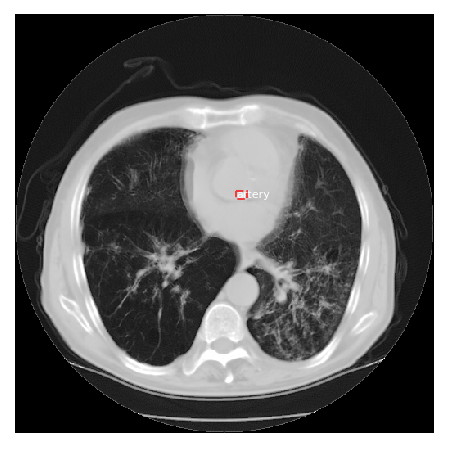

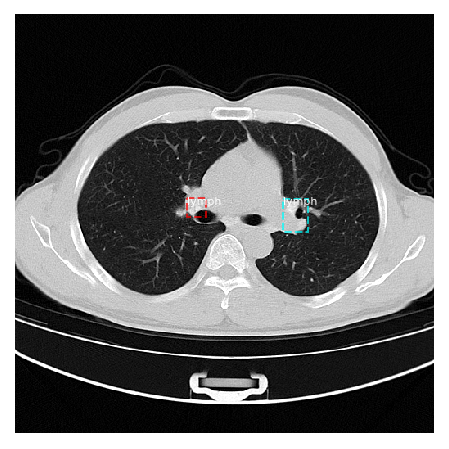

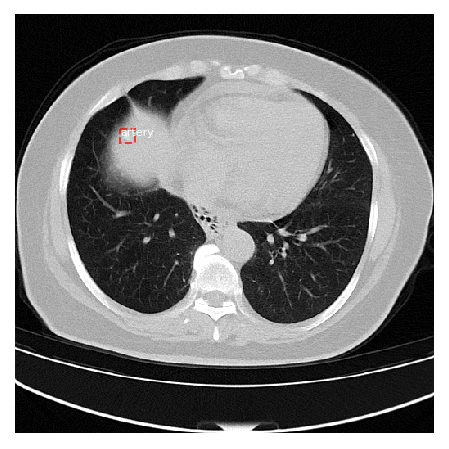

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 3)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    bbox, class_ids = dataset_train.load_bbox(image_id)
    mrcnn.visualize.display_instances(image, bbox, class_ids, dataset_train.class_names, figsize=(8, 8), cmap=plt.cm.gray)

In [7]:
# Create model in training mode
model = mrcnn.model.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=['conv1', "mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=300, 
            layers=r"(conv1)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)")


Starting at epoch 0. LR=0.001

Checkpoint Path: /mnt/disk2/CTdata/zhuhe/logs2/nodule20190716T1129/mask_rcnn_nodule_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_class_logits     (TimeDistributed)
Instructions for updating:
Use tf.cast instead.


/home/zhangsiyu/siyu/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/zhangsiyu/siyu/anaconda3/envs/py36/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/300
1024/1024 [==============================] - 675s 659ms/step - loss: 0.8252 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.5745 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.1879 - val_loss: 2.2517 - val_rpn_class_loss: 0.0223 - val_rpn_bbox_loss: 1.6803 - val_mrcnn_class_loss: 0.0152 - val_mrcnn_bbox_loss: 0.5339
Epoch 2/300
1024/1024 [==============================] - 633s 618ms/step - loss: 0.5935 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.3946 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.1405 - val_loss: 2.1919 - val_rpn_class_loss: 0.0168 - val_rpn_bbox_loss: 1.5000 - val_mrcnn_class_loss: 0.0337 - val_mrcnn_bbox_loss: 0.6414
Epoch 3/300
1024/1024 [==============================] - 643s 628ms/step - loss: 0.5933 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.4144 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.1244 - val_loss: 2.2711 - val_rpn_class_loss: 0.0173 - val_rpn_bbox_loss: 1.5848 - val_mrcnn_class_loss: 0.0591 - val_mrcnn_bbox_loss: 0.6099
Epoch 4/300
1024/10

1024/1024 [==============================] - 652s 636ms/step - loss: 0.5202 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.3336 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.1288 - val_loss: 2.7352 - val_rpn_class_loss: 0.0196 - val_rpn_bbox_loss: 2.0915 - val_mrcnn_class_loss: 0.0396 - val_mrcnn_bbox_loss: 0.5846
Epoch 27/300
1024/1024 [==============================] - 649s 634ms/step - loss: 0.4732 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.2915 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.1271 - val_loss: 2.7737 - val_rpn_class_loss: 0.0198 - val_rpn_bbox_loss: 2.1431 - val_mrcnn_class_loss: 0.0330 - val_mrcnn_bbox_loss: 0.5778
Epoch 28/300
1024/1024 [==============================] - 650s 635ms/step - loss: 0.5365 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.3364 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.1415 - val_loss: 2.7576 - val_rpn_class_loss: 0.0158 - val_rpn_bbox_loss: 1.7340 - val_mrcnn_class_loss: 0.0798 - val_mrcnn_bbox_loss: 0.9280
Epoch 29/300
1024/1024 [=====

1024/1024 [==============================] - 655s 640ms/step - loss: 0.4585 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.2785 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.1225 - val_loss: 2.8373 - val_rpn_class_loss: 0.0168 - val_rpn_bbox_loss: 1.9867 - val_mrcnn_class_loss: 0.0422 - val_mrcnn_bbox_loss: 0.7916
Epoch 52/300
1024/1024 [==============================] - 651s 636ms/step - loss: 12.2820 - rpn_class_loss: 0.1198 - rpn_bbox_loss: 11.9438 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.1696 - val_loss: 2.8171 - val_rpn_class_loss: 0.0123 - val_rpn_bbox_loss: 2.0778 - val_mrcnn_class_loss: 0.0523 - val_mrcnn_bbox_loss: 0.6747
Epoch 53/300
1024/1024 [==============================] - 651s 636ms/step - loss: 0.4842 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.2906 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.1341 - val_loss: 1.9974 - val_rpn_class_loss: 0.0110 - val_rpn_bbox_loss: 1.5455 - val_mrcnn_class_loss: 0.0277 - val_mrcnn_bbox_loss: 0.4132
Epoch 54/300
1024/1024 [===

In [10]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=5, 
            layers="all")


Starting at epoch 0. LR=0.0001

Checkpoint Path: /mnt/disk2/CTdata/zhuhe/logs2/nodule20190716T1129/mask_rcnn_nodule_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_b

In [11]:
class InferenceConfig(NoduleConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = mrcnn.model.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use tf.cast instead.
Loading weights from  /mnt/disk2/CTdata/zhuhe/logs2/nodule20190716T1129/mask_rcnn_nodule_0109.h5
Re-starting from epoch 109


original_image           shape: (512, 512, 1)         min:    0.00000  max: 1500.00000  int32
image_meta               shape: (17,)                 min:    0.00000  max:  747.00000  int64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int64
gt_bbox                  shape: (1, 4)                min:  283.50000  max:  349.00000  float64


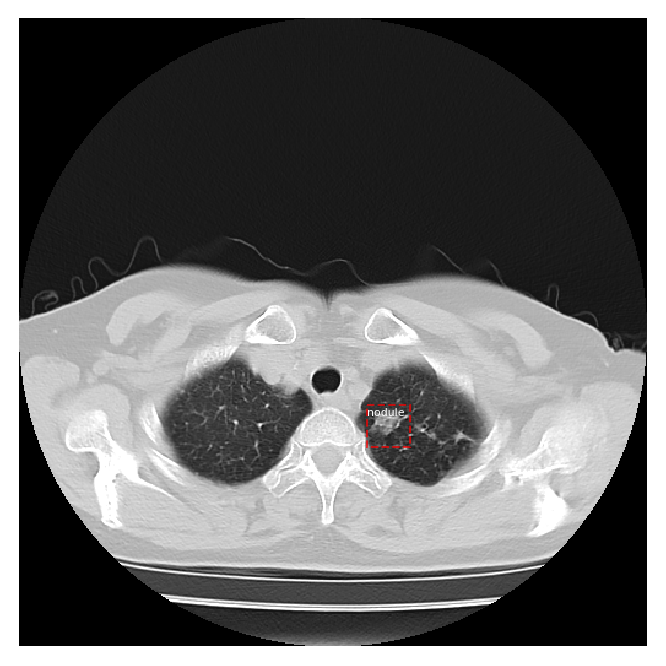

In [12]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
# original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
#     modellib.load_image_gt(dataset_val, inference_config, 
#                            image_id, use_mini_mask=False)
original_image, image_meta, gt_class_id, gt_bbox =\
    mrcnn.model.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

mrcnn.model.log("original_image", original_image)
mrcnn.model.log("image_meta", image_meta)
mrcnn.model.log("gt_class_id", gt_class_id)
mrcnn.model.log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

# visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
#                             dataset_train.class_names, figsize=(8, 8))
mrcnn.visualize.display_instances(original_image, gt_bbox, gt_class_id, 
                            dataset_train.class_names, figsize=(12, 12), cmap=plt.cm.gray)

Processing 1 images
image                    shape: (512, 512, 1)         min:    0.00000  max: 1500.00000  int32
molded_images            shape: (1, 512, 512, 1)      min: -538.00000  max:  962.00000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.08856  max:    0.99771  float32
[{'rois': array([[334, 351, 350, 369]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9132311], dtype=float32)}]


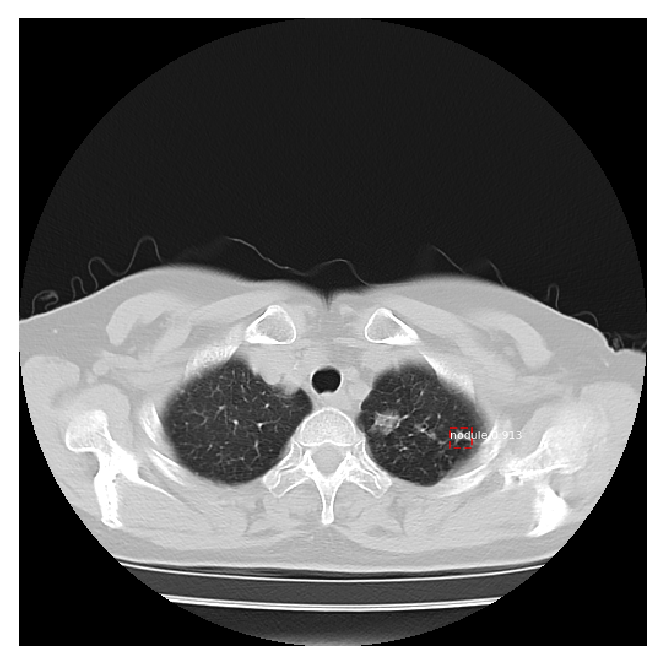

In [13]:
results = model.detect([original_image], verbose=1)
print(results)
r = results[0]
idx = r['scores'] > 0.9
r['rois'] = r['rois'][idx]
r['scores'] = r['scores'][idx]
r['class_ids'] = r['class_ids'][idx]
mrcnn.visualize.display_instances(original_image, r['rois'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], figsize=(12, 12), cmap=plt.cm.gray)